In [1]:
# Importare le librerie necessarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import os
import pickle
import json
import datetime
import joblib
import wandb

In [2]:
from scipy.signal import butter,filtfilt # Filter requirements.
T = 0.005         # Sample Period
fs = 1/T       # sample rate, Hz
cutoff = 1    # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hznyq = 0.5 * fs  # Nyquist Frequencyorder = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples
nyq = 0.5 * fs  # Nyquist Frequencyorder = 2       # sin wave can be approx represented as quadratic

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [3]:
files_dict = {}
def create_dataframe_from_files(directory):
    data_list = []
    for root, dirs, files in os.walk(directory):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            # Esempio: lettura di dati da file CSV
            if file_name.endswith('.csv'):
                df = pd.read_csv(file_path)
                print(file_name, "---", len(df))
                files_dict[file_name] = len(df)
                df["Tempo (ms)"] = df["Tempo (ms)"].astype(float)
                df["Forza (N)"] = df["Forza (N)"].astype(float)
                df["Valvola"] = df["Stato X11"].astype(float)
                df["Pressione"] = df["Pressione"].astype(float)
                df["Voltaggio"] = df["Voltaggio"].astype(float)
                df = df.reindex(columns=["Tempo (ms)","Voltaggio","Valvola","Pressione"])
                # df = pd.concat([df_header, df], ignore_index=True)
                
                pressure = df["Pressione"].tolist()[500:]
                filtered = butter_lowpass_filter(pressure, cutoff, fs, order=2)
                gradient = np.gradient(filtered, 0.005)
                
                start = 500+gradient.tolist().index(gradient.max())-50
                end = 500+gradient.tolist().index(gradient[1000+start:].max())-100
                
                
                # plt.plot(pressure, label="pressure")
                # plt.plot(filtered, label="filtered")
                # plt.plot(gradient, label="gradient")
                # plt.axvline(start, color='r')
                # plt.axvline(end, color='r')
                # plt.legend()
                # plt.title(file_name)
                # plt.show()
                
                data_cut = df.iloc[start:end]
                data_cut["Tempo (ms)"] = np.arange(0,end-start)*0.005
                data_list.append(data_cut)

    if data_list:
        # return pd.concat(data_list, ignore_index=True)
        return data_list
    else:
        return None

In [4]:
df_unseens = create_dataframe_from_files("/home/etosin/Documents/isaaclab_supsi/vacuum/test_DOE_5milli")

test39_updated_5milli.csv --- 3984
test34_updated_5milli.csv --- 4141
test21_updated_5milli.csv --- 4068
test28_updated_5milli.csv --- 3990


/tmp/ipykernel_48914/1980670748.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cut["Tempo (ms)"] = np.arange(0,end-start)*0.005
/tmp/ipykernel_48914/1980670748.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cut["Tempo (ms)"] = np.arange(0,end-start)*0.005
/tmp/ipykernel_48914/1980670748.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [5]:
def pad_dfs(dfs):
    new_dfs = []
    for df in dfs:
        tmp = pd.DataFrame(np.array(df.iloc[0].tolist()*10).reshape(10, -1), columns=df.columns)
        df = pd.concat([tmp, df], axis=0, ignore_index=True)
        new_dfs.append(df)
    return new_dfs

In [6]:
df_unseens = pad_dfs(df_unseens)

In [7]:
data = next(iter(df_unseens))

voltage = data["Voltaggio"]
time = data["Tempo (ms)"]

In [8]:
def create_sequences(features, targets, seq_length):
    sequences = []
    for i in range(len(features) - seq_length):
        seq = features[i:i+seq_length]
        label = targets[i+seq_length]
        sequences.append((seq.tolist(), label.tolist()))
    return sequences

In [9]:
def evaluate_model_unseen(lstm_model, df_unseen, helper):
    df_unseen["V"] = (df_unseen["Voltaggio"]+1)/6

    mask_valvola_on = df_unseen["Valvola"]<=0.5
    mask_valvola_off = df_unseen["Valvola"]>0.5
    
    df_unseen.loc[mask_valvola_on, "V"] = 0
    df_unseen.loc[mask_valvola_on, "Valvola"] = 1
    df_unseen.loc[mask_valvola_off, "Valvola"] = 0
    
    X = df_unseen[['Tempo (ms)', 'V']].values
    y = df_unseen['Pressione'].values
    
    
    X = helper.scaler.transform(X)
    
    seq = create_sequences(X, y, helper.seq_length)
    X, y_true = zip(*seq)
    
    
    lstm_model.eval()
    with torch.no_grad():
        pred_lstm = lstm_model(torch.tensor(X, device=helper.device).float()).flatten().tolist()
    
    return y_true, pred_lstm

In [10]:
from LSTM_Helper import LSTM_Helper
helper = LSTM_Helper()

forces_helper = helper.predict(time, voltage)

true_press, pred_lstm = evaluate_model_unseen(helper.model, data, helper)
true_forces = [helper.compute_force(p) for p in true_press]
forces_lstm = [helper.compute_force(p) for p in pred_lstm]

/home/etosin/miniconda3/envs/isaaclab_github/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 1.4.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/etosin/miniconda3/envs/isaaclab_github/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


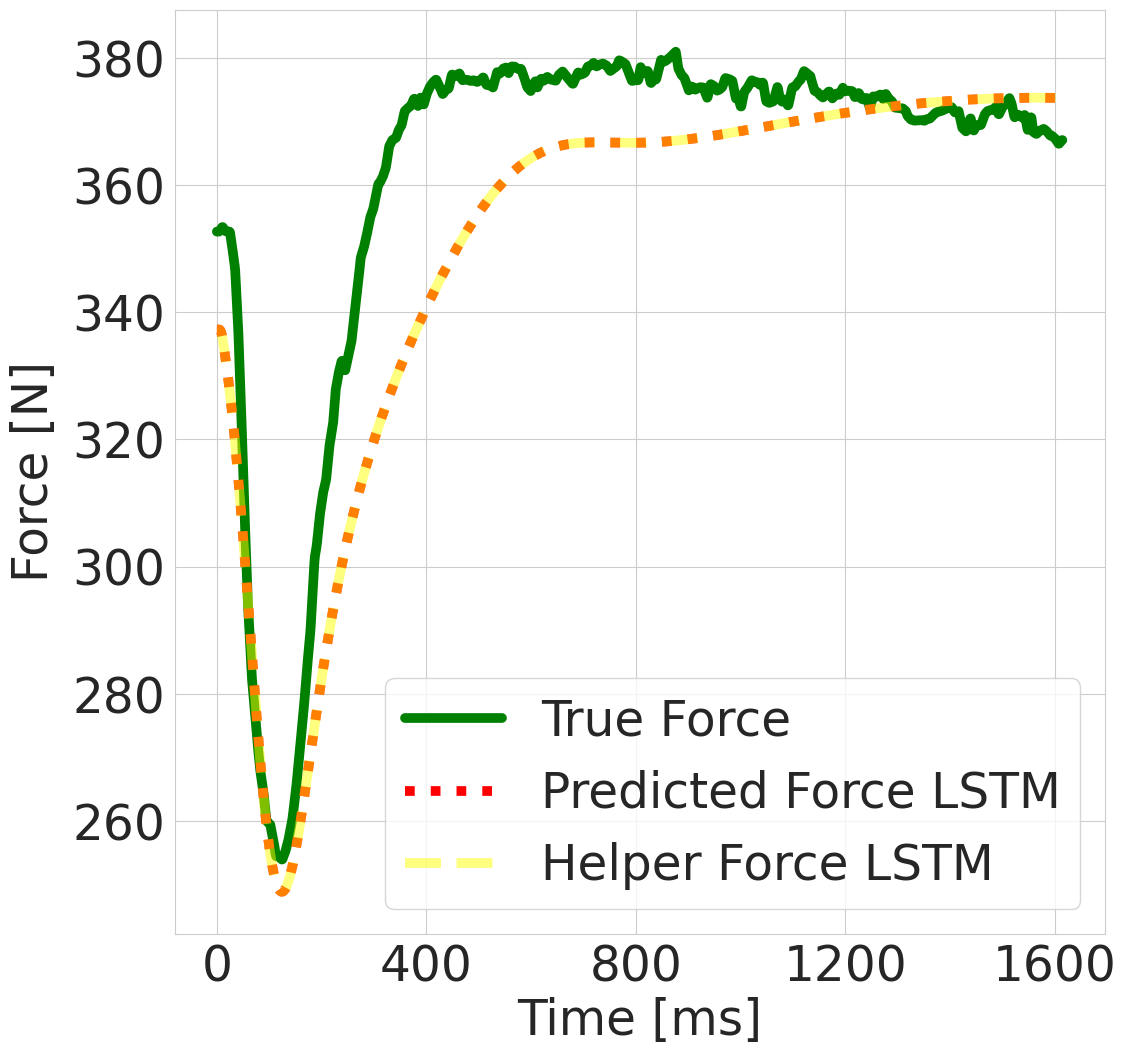

In [14]:
fontsize = 35
linewidth = 7
plt.figure(figsize=(12,12))
plt.plot(true_forces, label='True Force', linewidth=linewidth, color="green")
plt.plot(forces_lstm, label='Predicted Force LSTM', linestyle='dotted', linewidth=linewidth, color="red")
plt.plot(forces_helper, label='Helper Force LSTM', linestyle='--', linewidth=linewidth, color="yellow", alpha=0.5)
plt.xlabel('Time [ms]', fontsize=fontsize)
plt.ylabel('Force [N]', fontsize=fontsize, labelpad=10)
ticks = [0, 400, 800, 1200, 1600]
plt.xticks(ticks=ticks, fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()